In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt

In [2]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [3]:
def load_housing_data():
    tarball_path = Path('datasets/housing.tgz')
    if not tarball_path.is_file():
        Path('datasets').mkdir(parents=True, exist_ok=True)
        url = 'https://github.com/ageron/data/raw/main/housing.tgz'
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path='datasets', filter='data')
    return pd.read_csv(Path('datasets/housing/housing.csv'))

housing_full = load_housing_data()

In [4]:
housing_full.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
IMAGES_PATH = Path('images', 'end_to_end_project')
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension='png', dpi=300):
    path = IMAGES_PATH / f'{fig_id}.{fig_extension}'
    if tight_layout:
        plt.tight_layout()
        plt.savefig(path, format=fig_extension, dpi=dpi)

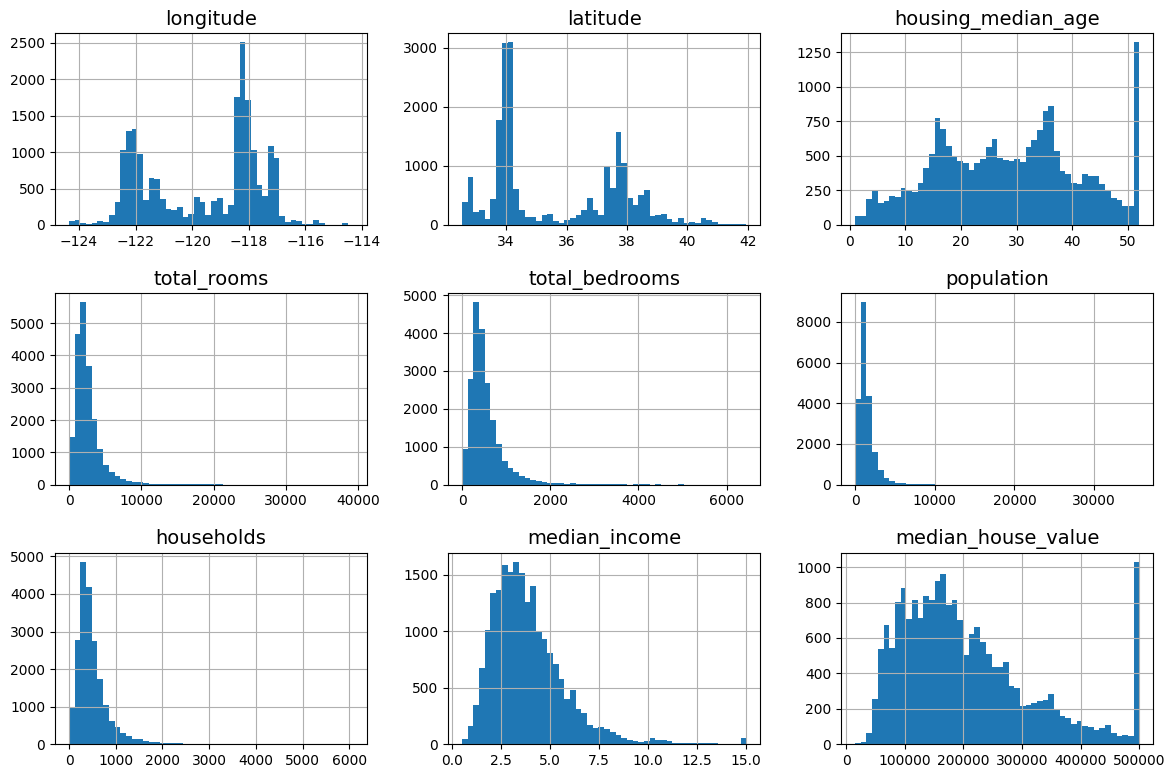

In [7]:
housing_full.hist(bins=50, figsize=(12, 8))
save_fig('attribute_histogram_plots')
plt.show()

In [8]:
from scipy.stats import binom

sample_size = 1000
ratio_female = 0.516

proba_too_small = binom(sample_size, ratio_female).cdf(490 - 1)
proba_too_large = 1 - binom(sample_size, ratio_female).cdf(540)

print(proba_too_small + proba_too_large)

0.10727422667455615


In [9]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing_full, test_size=0.2, random_state=42)

In [10]:
housing_full['income_cat'] = pd.cut(housing_full['median_income'],
                                    bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
                                    labels=[1, 2, 3, 4, 5])

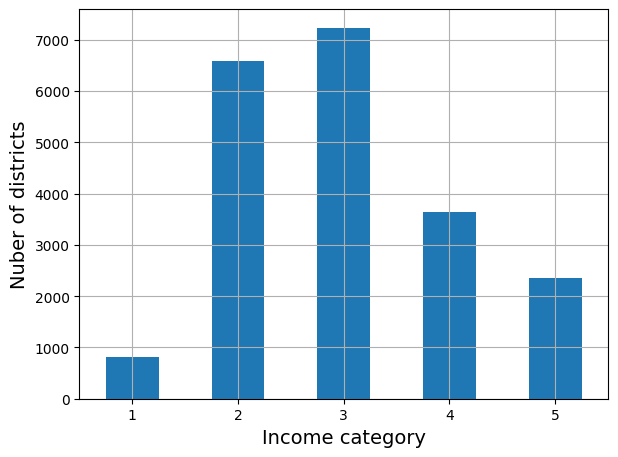

In [11]:
cat_counts = housing_full['income_cat'].value_counts().sort_index()
cat_counts.plot.bar(rot=0, grid=True)
plt.xlabel('Income category')
plt.ylabel('Nuber of districts')
save_fig('housing_income_cat_bar_plot')
plt.show()

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing_full,
                                              housing_full['income_cat']):
    strat_train_set_n = housing_full.iloc[train_index]
    strat_test_set_n = housing_full.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])


In [13]:
strat_train_set, strat_test_set = strat_splits[0]

In [14]:
strat_train_set, strat_test_set = train_test_split(housing_full, test_size=0.2, stratify=housing_full['income_cat'], random_state=42)

In [15]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [16]:
def income_cat_proportions(data):
    return data['income_cat'].value_counts() / len(data)

train_set, test_set = train_test_split(housing_full, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    'Overall %': income_cat_proportions(housing_full),
    'Stratified %': income_cat_proportions(strat_test_set),
    'Random %': income_cat_proportions(test_set)
}).sort_index()

compare_props.index.name = 'Income Category'
compare_props['Strat. Error %'] = (compare_props['Stratified %'] / compare_props['Overall %'] - 1)
compare_props['Rand. Error %'] = (compare_props['Random %'] / compare_props['Overall %'] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [17]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

# Visualizing data

In [18]:
housing = strat_train_set.copy()

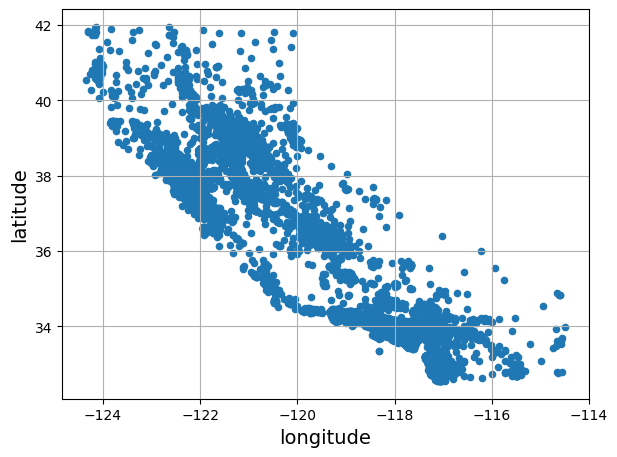

In [19]:
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True)
save_fig('bad_visualization_plot')
plt.show()

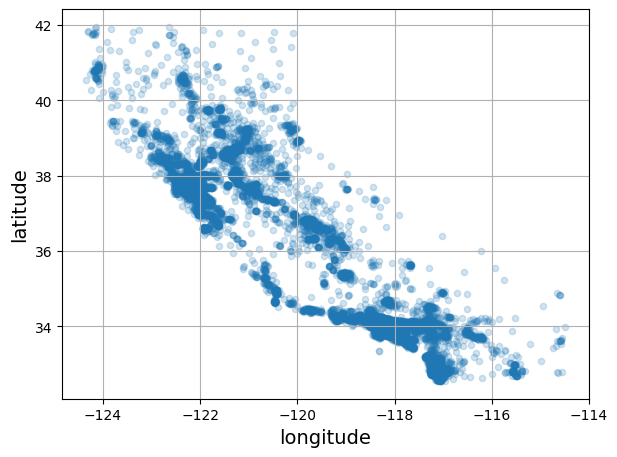

In [20]:
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True, alpha=0.2)
save_fig('better_visualization_plot')
plt.show()

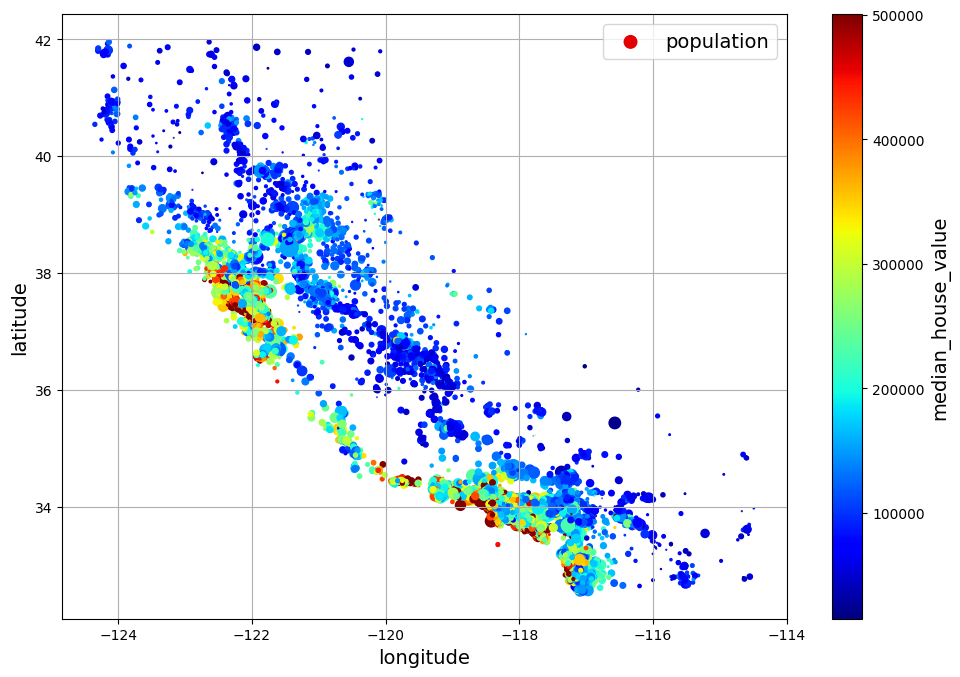

In [21]:
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True,
             s=housing['population'] / 100, label='population', c='median_house_value', cmap='jet',
             colorbar=True, legend=True, sharex=False, figsize=(10, 7))
save_fig('housing_prices_scatterplot')
plt.show()

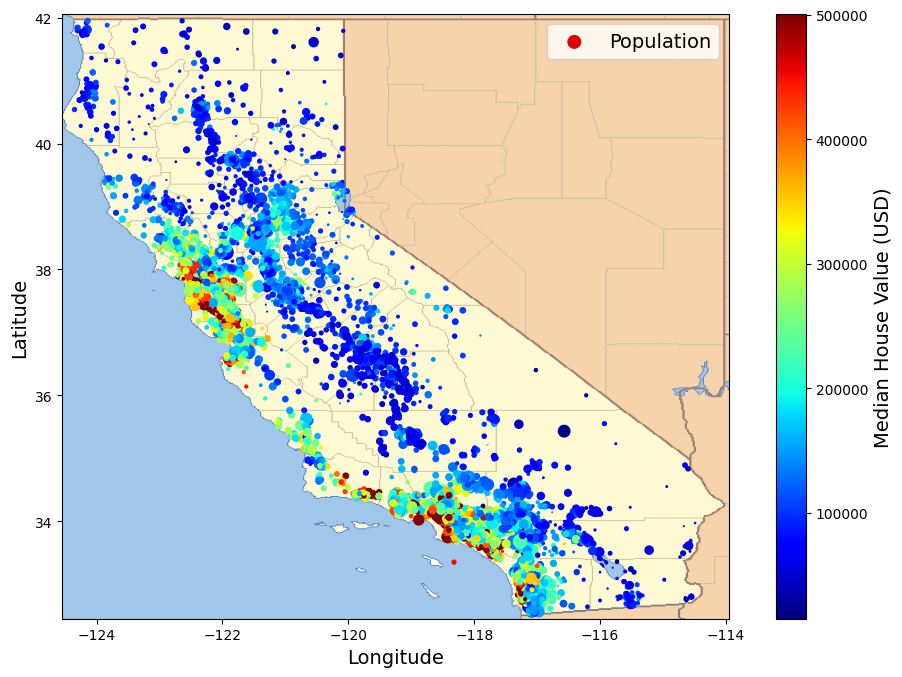

In [25]:
filename = 'california.png'

if not (IMAGES_PATH / filename).is_fifo():
    homlp_root = 'https://github.com/ageron/handson-mlp/raw/main/'
    url = homlp_root + 'images/end_to_end_project/' + filename
    print(f'Downloading {url} to {IMAGES_PATH / filename}')
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)

housing_renamed = housing.rename(columns={
    'latitude': 'Latitude',
    'longitude': 'Longitude',
    'population': 'Population',
    'median_house_value': 'Median House Value (USD)'
})

housing_renamed.plot(kind='scatter', x='Longitude', y='Latitude',
                     s=housing_renamed['Population'] / 100, label='Population',
                     c='Median House Value (USD)', cmap='jet', colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

save_fig('california_housing_prices_plot')
plt.show()

# Correlations

In [22]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

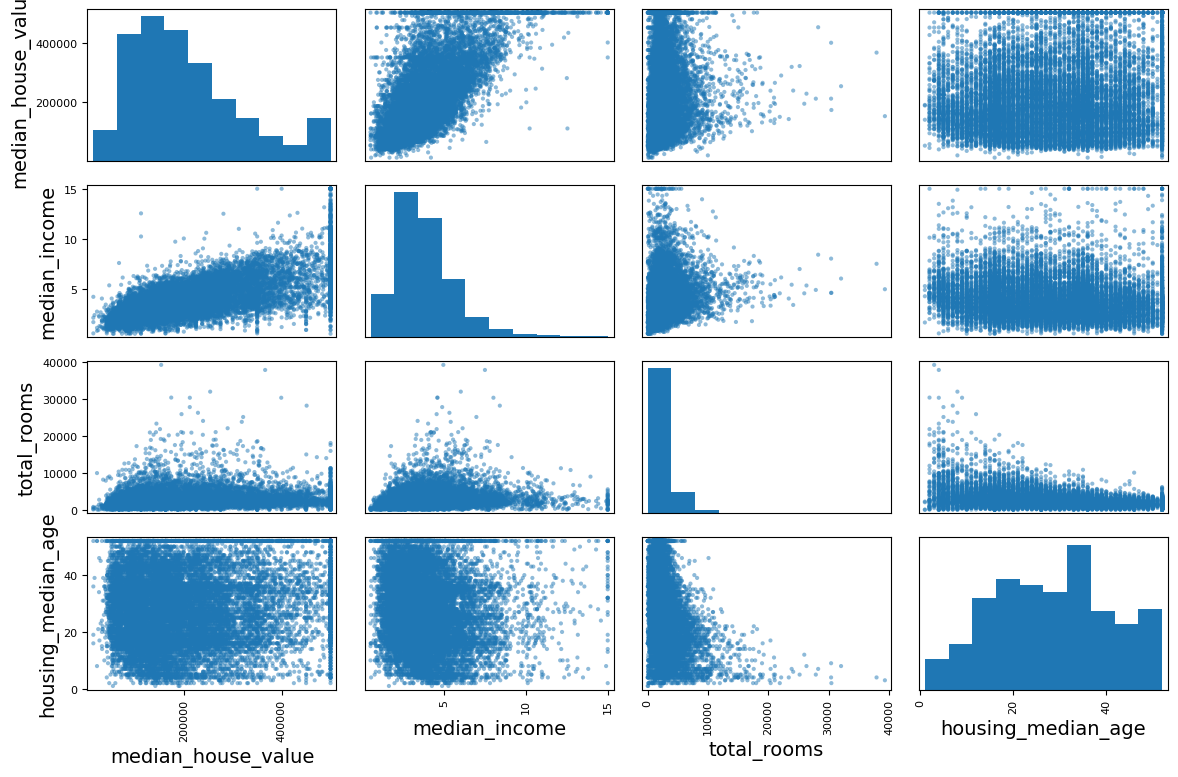

In [26]:
from pandas.plotting import scatter_matrix

attributes = [
    'median_house_value',
    'median_income',
    'total_rooms',
    'housing_median_age'
]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig('scatter_matrix_plot')
plt.show()

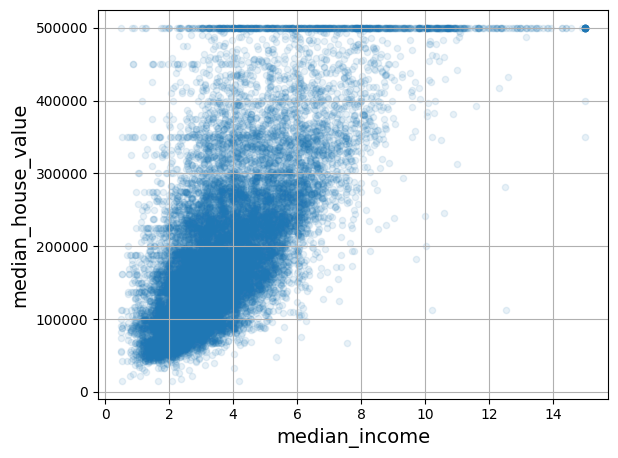

In [27]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, grid=True)
save_fig('income_vs_house_value_scatterplot')
plt.show()

# Experimenting with Attribute Combinations

In [28]:
housing['rooms_per_house'] = housing['total_bedrooms'] / housing['households']
housing['bedrooms_ratio'] = housing['total_bedrooms'] / housing['total_rooms']
housing['people_per_house'] = housing['population'] / housing['households']

In [29]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
rooms_per_house      -0.045545
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

# Prepare Data for ML Algorithms

In [30]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [31]:
# Deal with missing values by filling with median
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

In [32]:
# Separate numerical data as median can't be used on text data
housing_num = housing.select_dtypes(include=[np.number])

In [33]:
imputer.fit(housing_num)

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [34]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [35]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [36]:
X = imputer.transform(housing_num)

In [37]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)